In [1]:
import os
import scenicplus
import scanpy as sc
import warnings
import pandas as pd
import matplotlib as mpl
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

work_dir = '/data/leuven/345/vsc34561/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'

# Loading Data

In [2]:
adata = sc.read_mtx(os.path.join(rnaseq_dir, 'snRNA_counts.mtx')).T

In [3]:
genes = pd.read_csv(os.path.join(rnaseq_dir, 'genes.csv'), sep='\t', header=None).iloc[:, -1].values
adata.var = pd.DataFrame(index=genes)

# barcodes = pd.read_csv(os.path.join(rnaseq_dir, 'barcodes_rna.csv'), sep='\t', header=None).iloc[:, -1].values
# adata.obs = pd.DataFrame(index=barcodes)

metadata = pd.read_csv(os.path.join(rnaseq_dir, 'snRNA_metadta.csv'), sep=',') #.iloc[:, -1].values
metadata.index = metadata.iloc[:,0]
metadata = metadata.rename(columns={'Unnamed: 0': 'rna_barcode'})
adata.obs = metadata

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 61472 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

In [5]:
adata = adata[adata.obs['celltype'] == 'ODC']
adata

View of AnnData object with n_obs × n_vars = 37052 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

# Basic Filtering

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


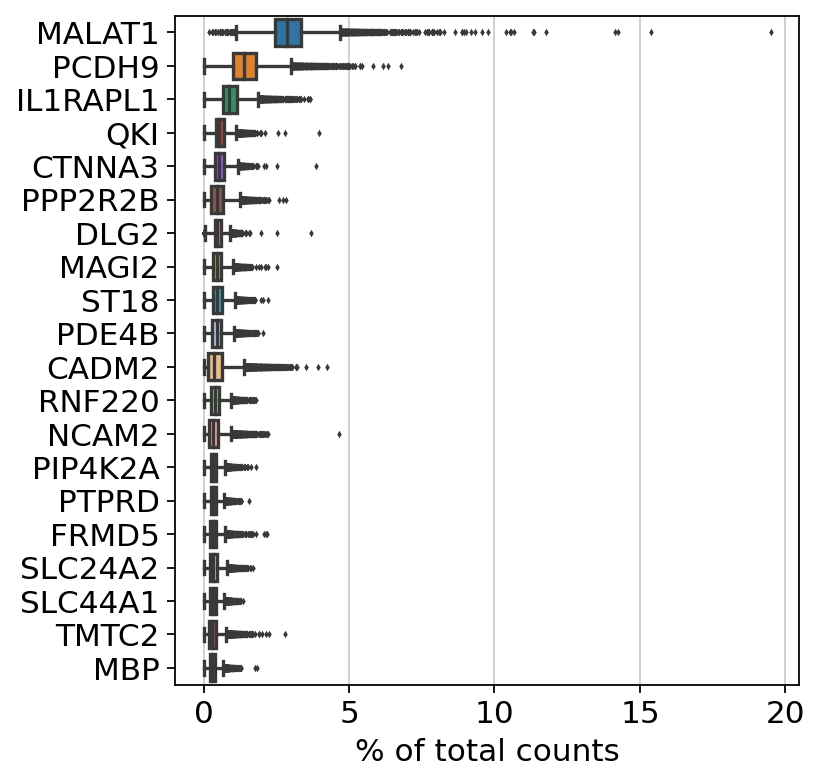

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

AnnData object with n_obs × n_vars = 37052 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes'
    var: 'n_cells'

In [8]:
sc.external.pp.scrublet(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


In [9]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 37051 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet'

In [10]:
sum(adata.var_names.str.startswith('MT-'))

0

In [11]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 37051 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

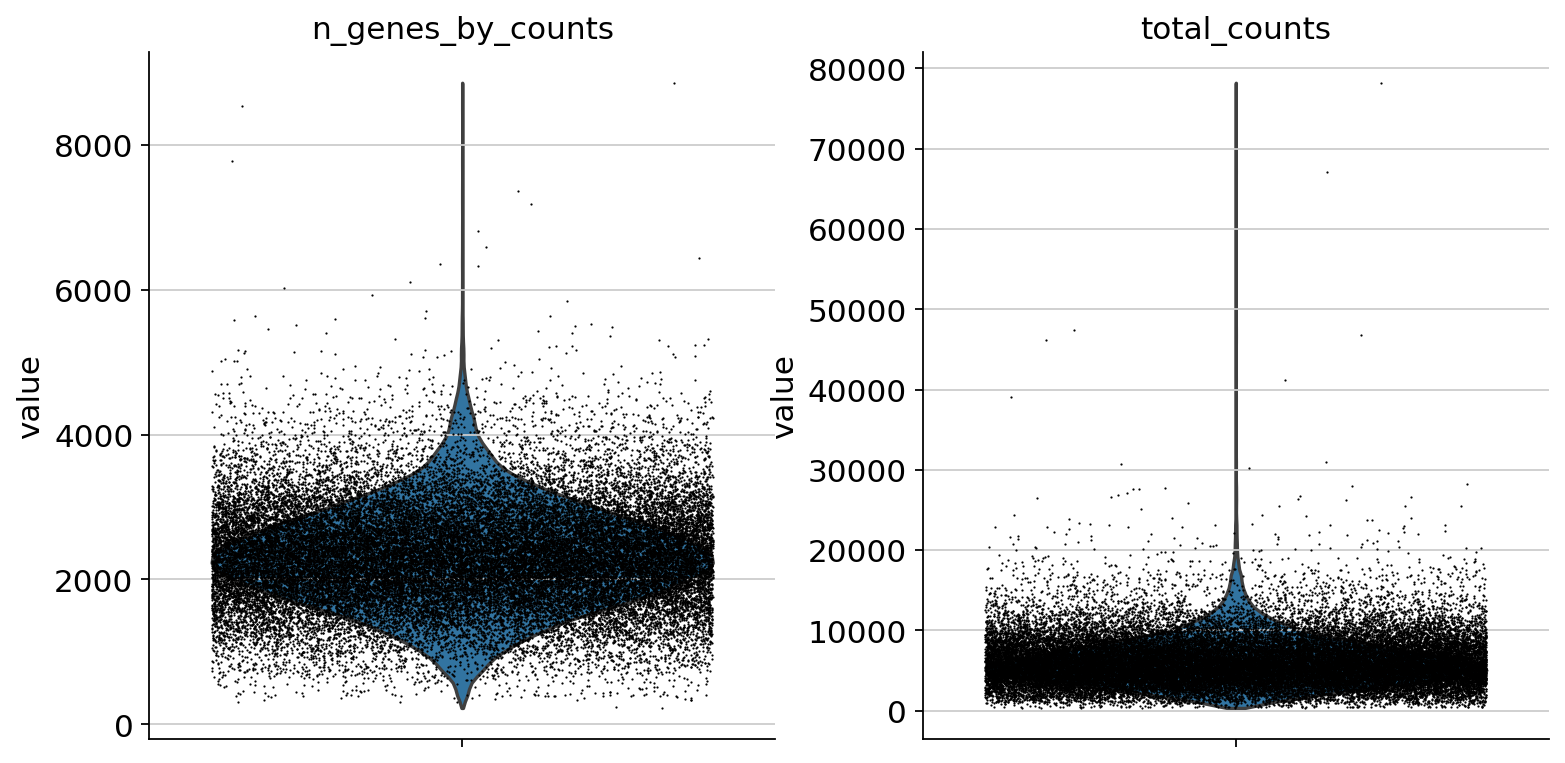

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

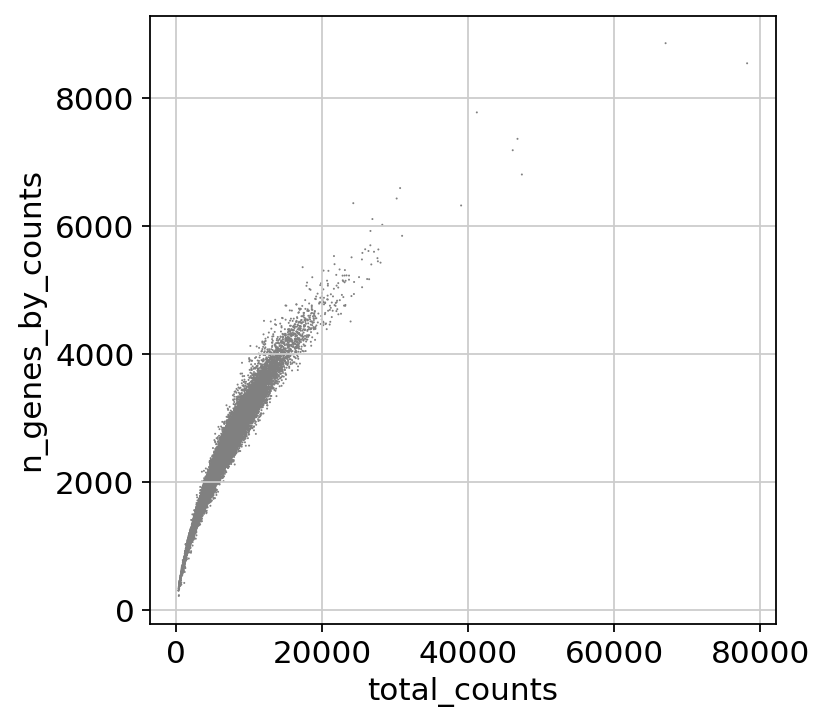

In [13]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata

View of AnnData object with n_obs × n_vars = 36382 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [15]:
adata = adata[adata.obs.total_counts < 10000, :]
adata

View of AnnData object with n_obs × n_vars = 33424 × 30959
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

# Data Normalization

In [16]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [17]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'Batch'])
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 33424 × 3663
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg'

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


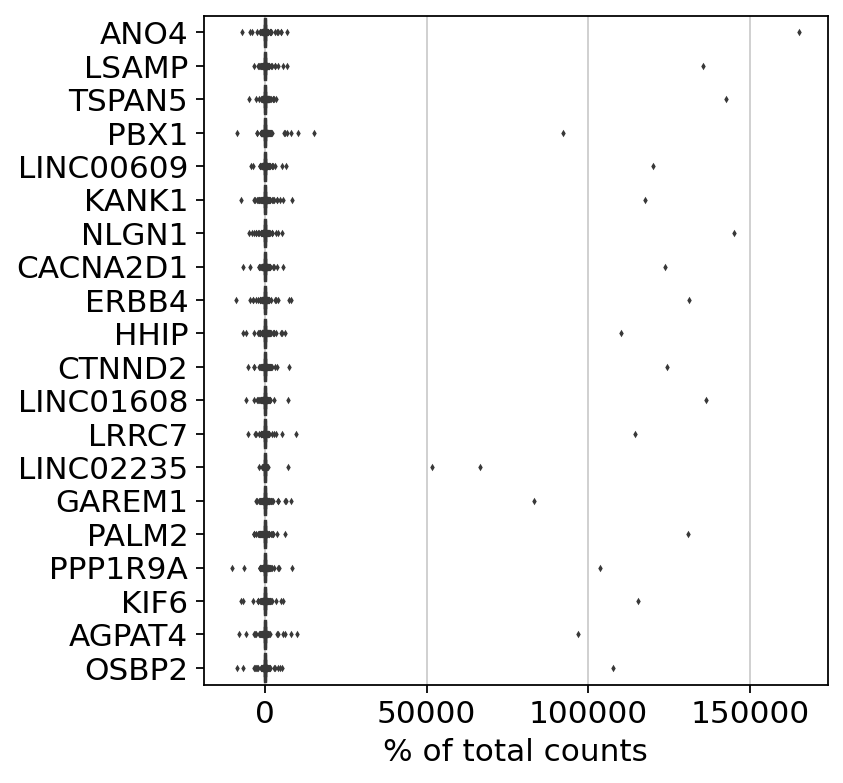

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# PCA

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

In [20]:
adata

AnnData object with n_obs × n_vars = 33424 × 3663
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

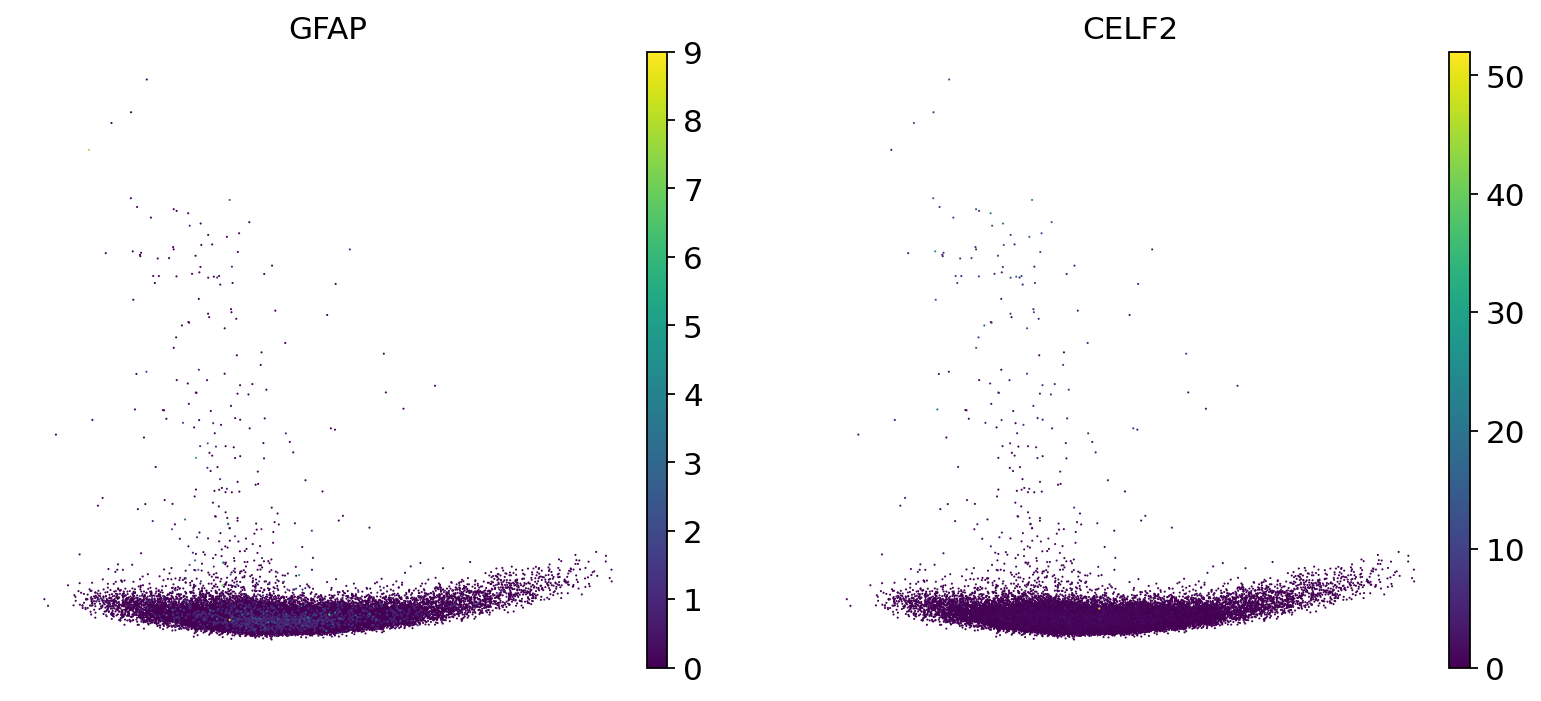

In [21]:
sc.pl.pca(adata, color=['GFAP', 'CELF2'])

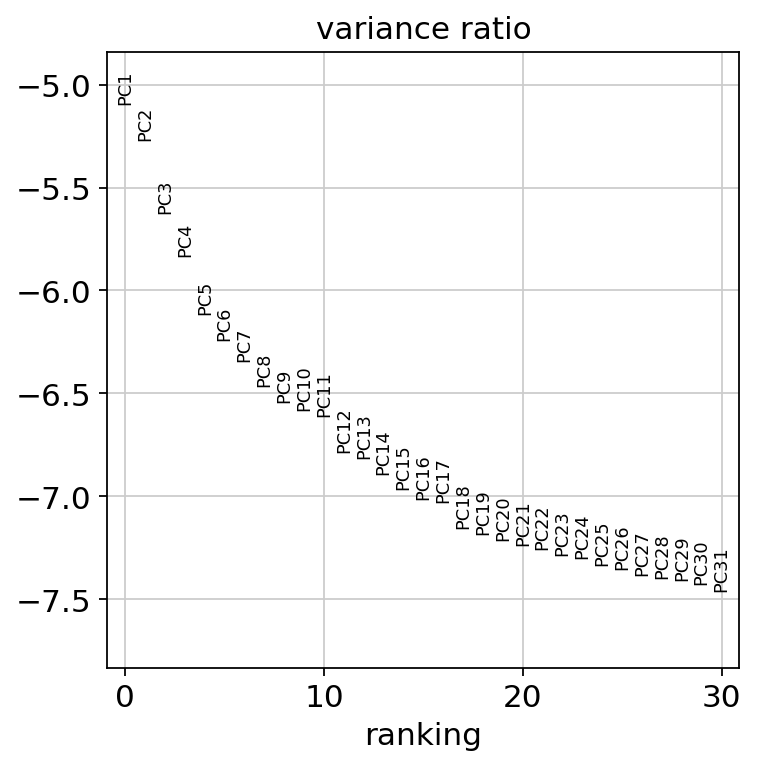

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

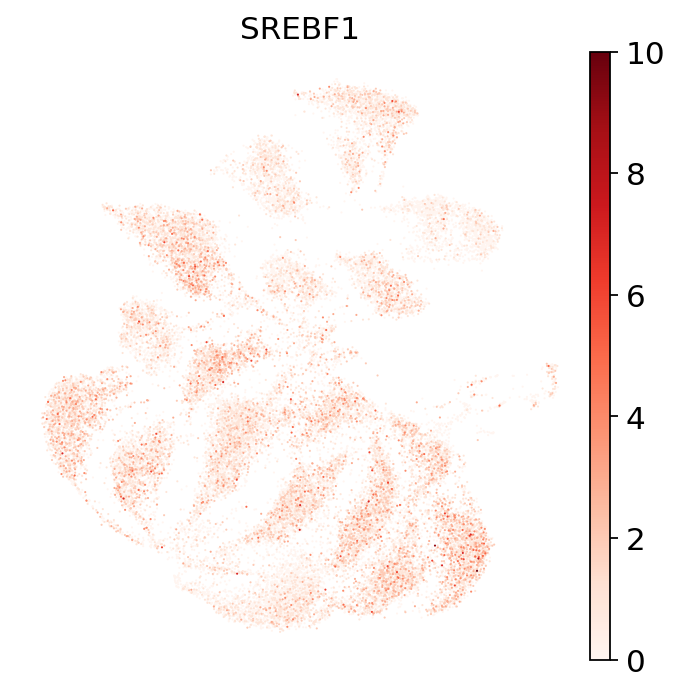

In [24]:
sc.pl.umap(adata, color=['SREBF1'], palette="Set2", color_map=mpl.cm.Reds)

In [25]:
sc.tl.leiden(adata)

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


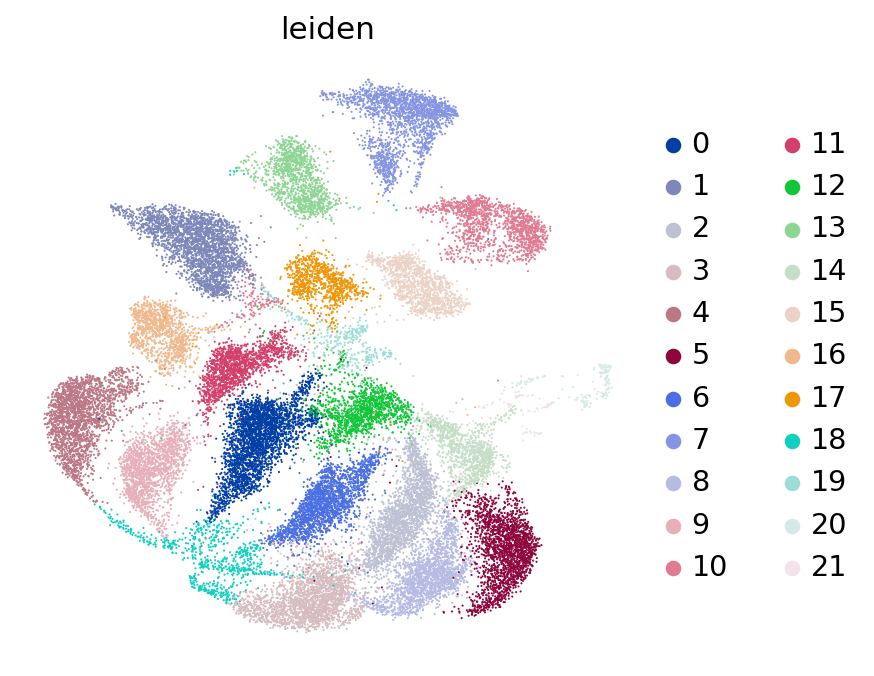

In [26]:
sc.pl.umap(adata, color=['leiden'])

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


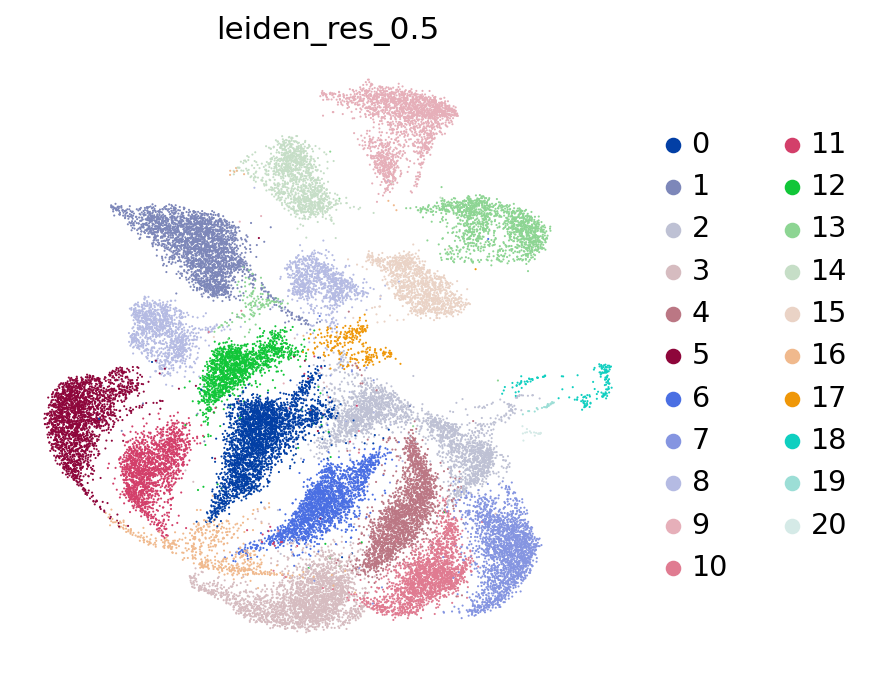

In [27]:
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden_res_0.5')
sc.pl.umap(adata, color = 'leiden_res_0.5')

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


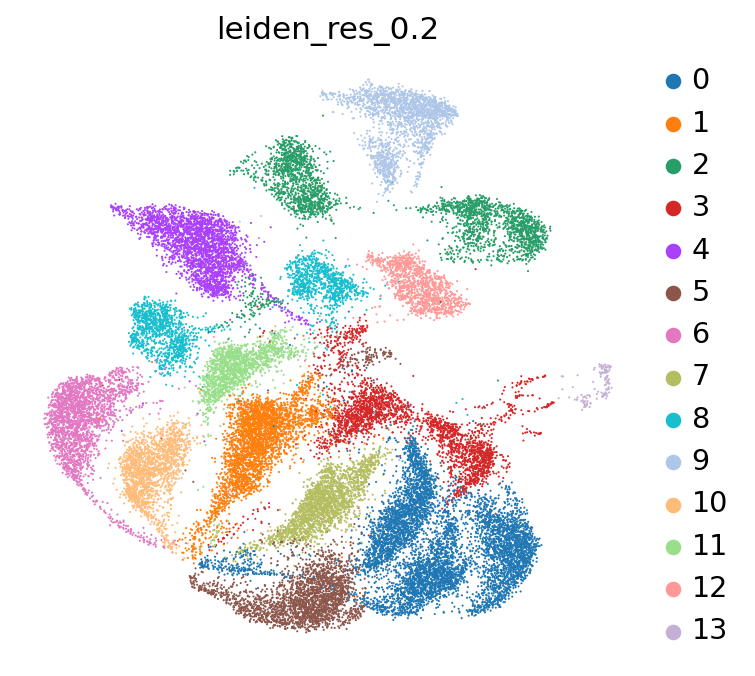

In [28]:
sc.tl.leiden(adata, resolution = 0.2, key_added = 'leiden_res_0.2')
sc.pl.umap(adata, color = 'leiden_res_0.2')

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


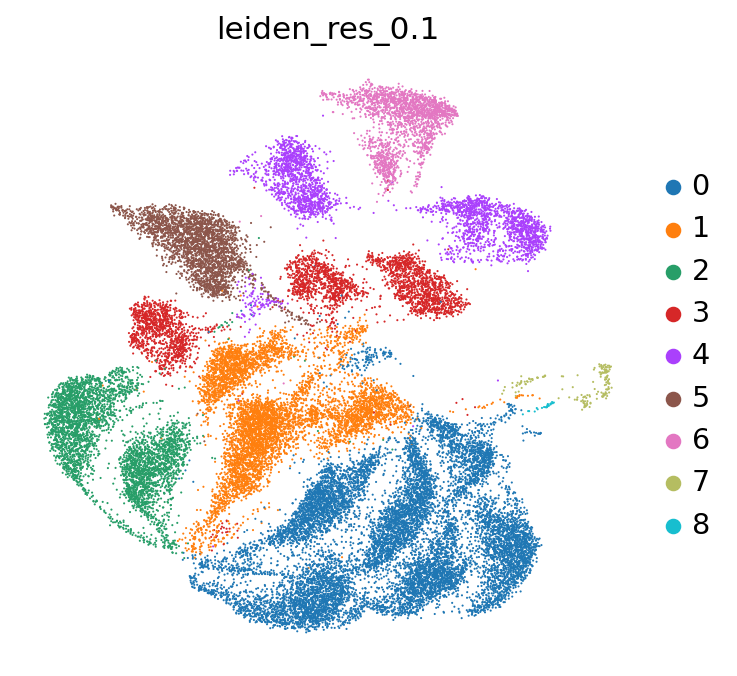

In [29]:
sc.tl.leiden(adata, resolution = 0.1, key_added = 'leiden_res_0.1')
sc.pl.umap(adata, color = 'leiden_res_0.1')

# Cell type annotation via metadata

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


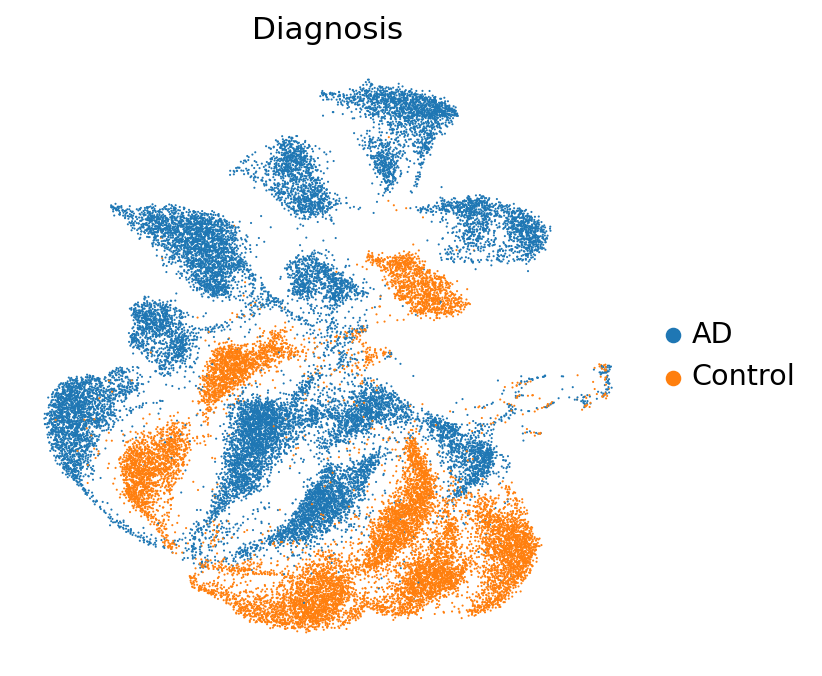

In [30]:
sc.pl.umap(adata, color='Diagnosis')

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


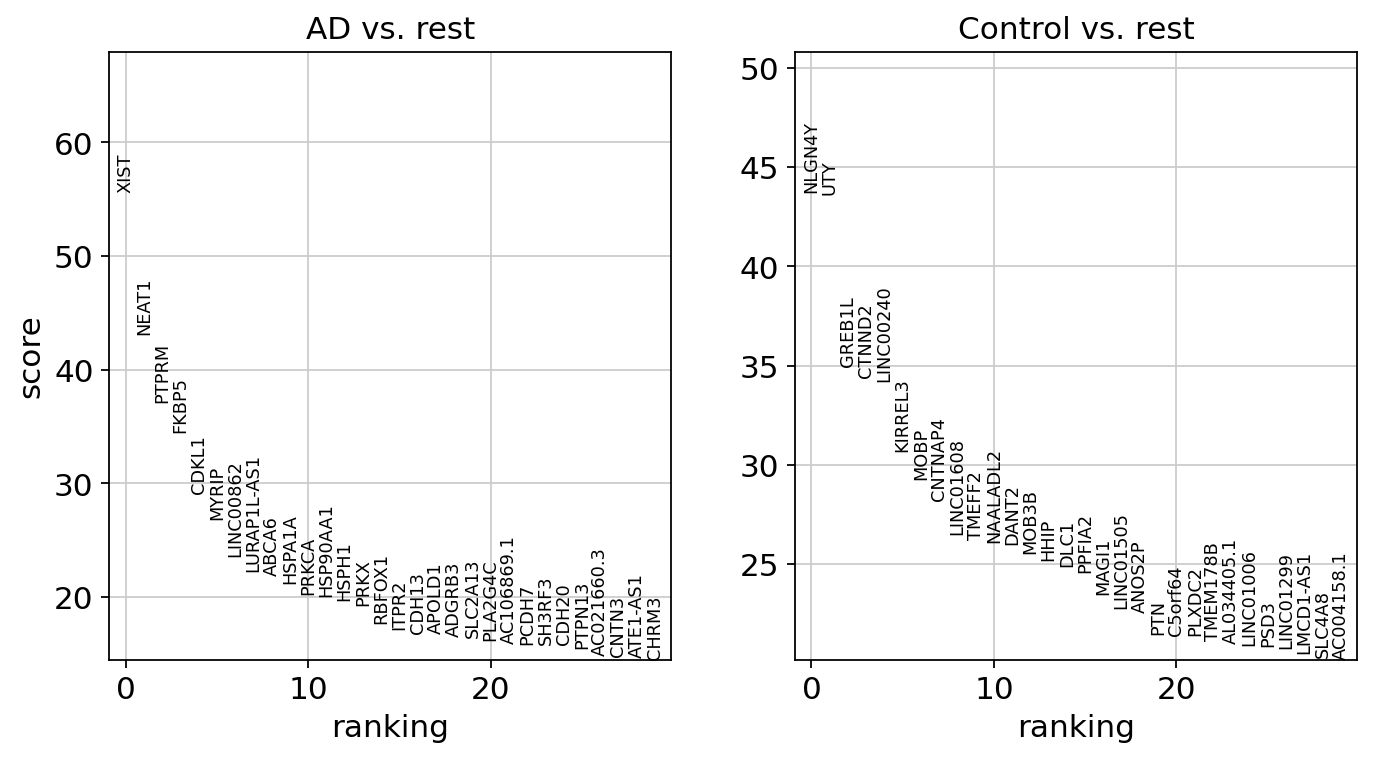

In [31]:
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

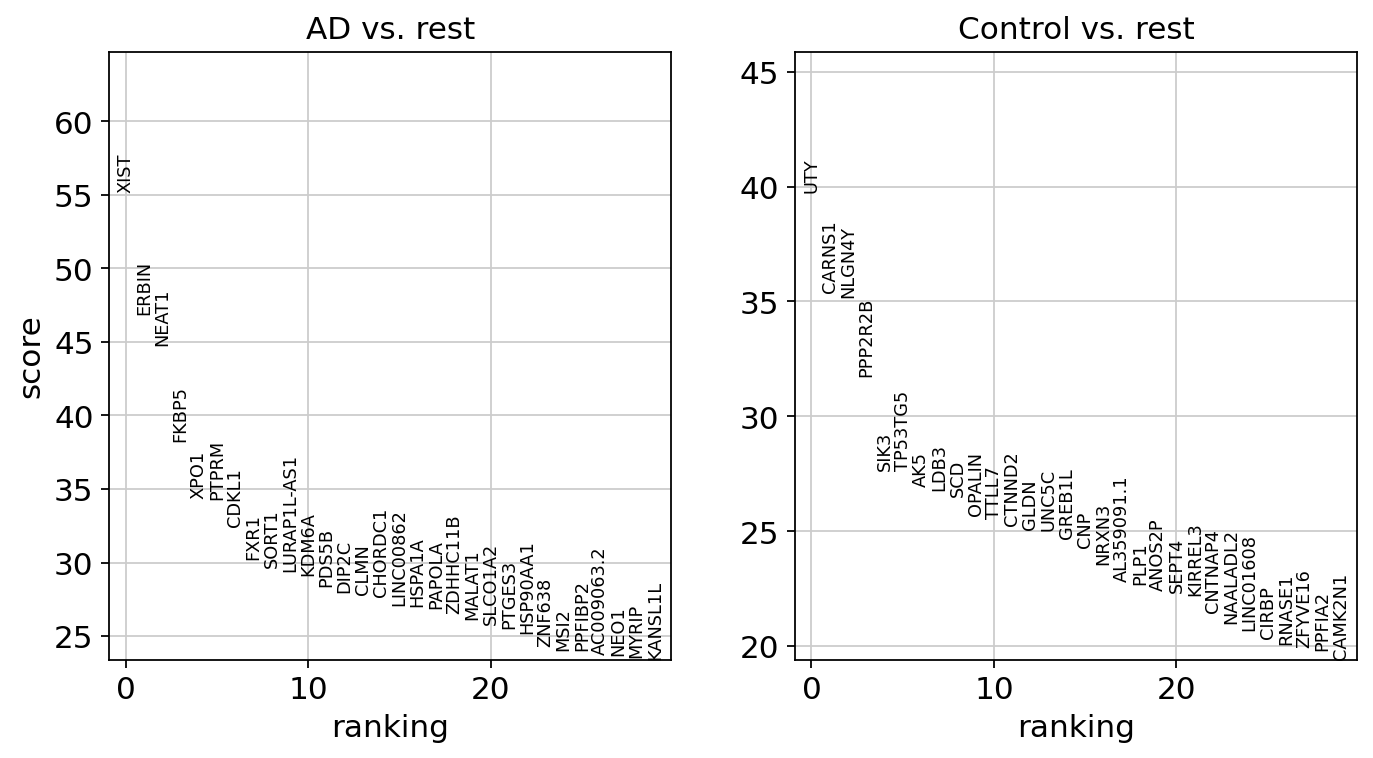

In [32]:
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

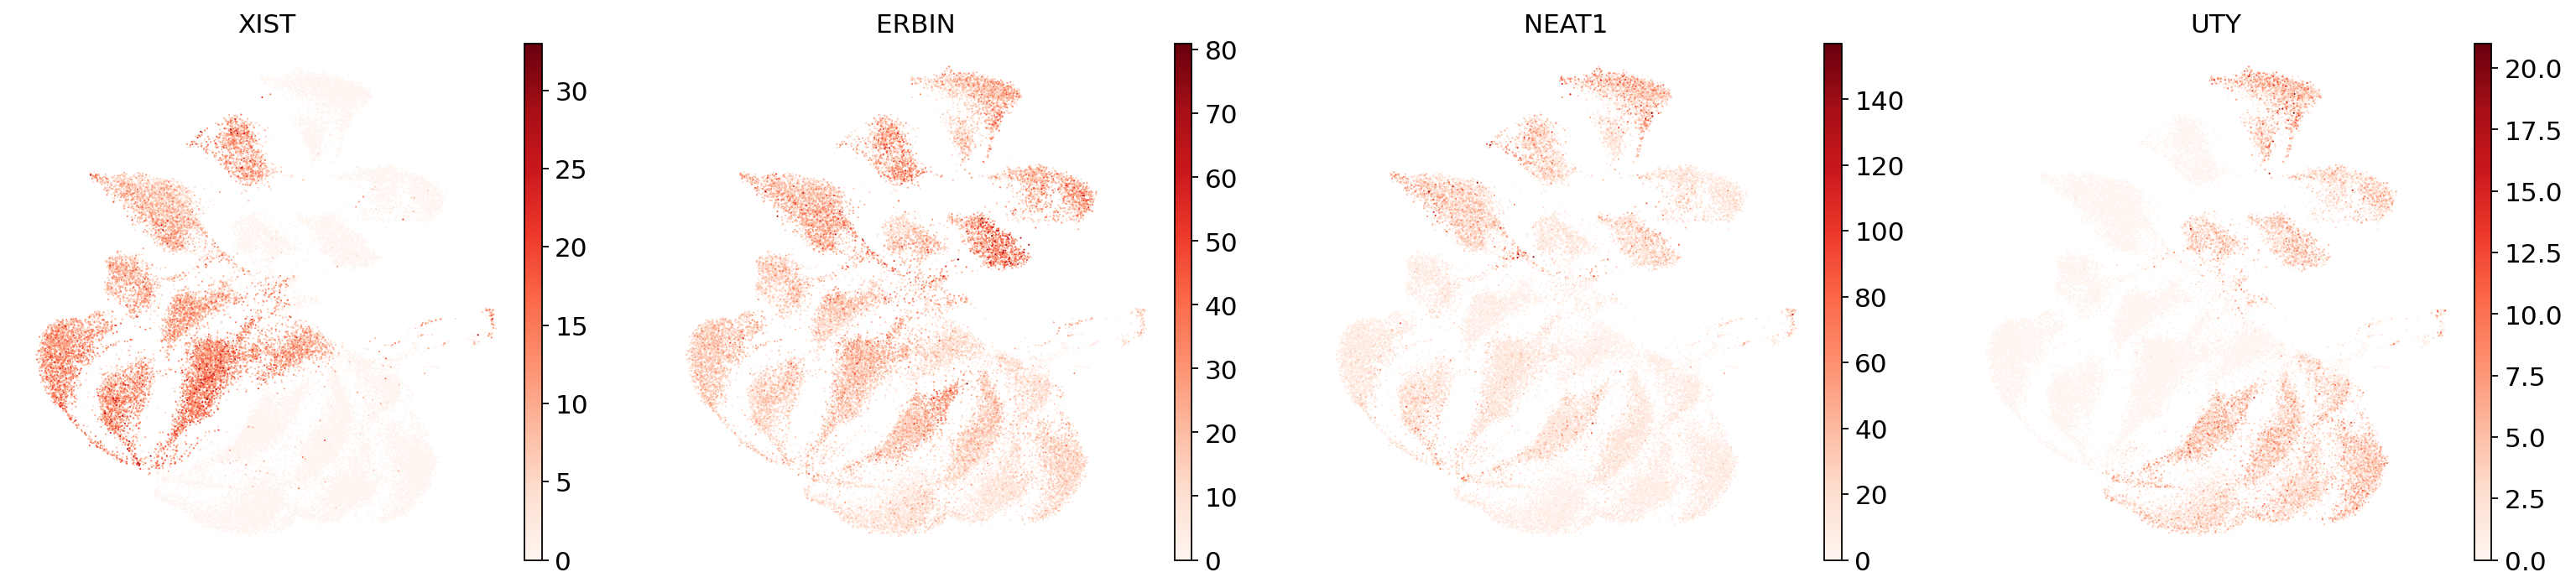

In [36]:
sc.pl.umap(adata, color=['XIST', 'ERBIN', 'NEAT1', 'UTY'], palette="Set2", color_map=mpl.cm.Reds)

# Saving the data

In [34]:
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'odc_state')

In [38]:
adata.raw.to_adata().write(os.path.join(mg_state, 'alzheimers.raw.h5ad'), compression='gzip')
adata.write(os.path.join(mg_state, 'alzheimers.h5ad'), compression='gzip') 

# Loading data

In [ ]:
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
adata.obs.head()

# ATAC-seq data

In [39]:
atac_metadata = pd.read_csv(os.path.join(atacseq_dir, 'snATAC_metadta.csv'), sep=',') #.iloc[:, -1].values
atac_metadata.index = atac_metadata.iloc[:,0]
atac_metadata = atac_metadata.rename(columns={'Unnamed: 0': 'barcode'})
atac_metadata['sample_id'] = 'alzheimers'
atac_metadata['celltype'] = atac_metadata['celltype'].astype(str)
atac_metadata

barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACGAAAGAAACGCC-13  AAACGAAAGAAACGCC-13   Sample-96      1   M   79   
AAACGAAAGAAATGGG-11  AAACGAAAGAAATGGG-11  Sample-101      2   F   74   
AAACGAAAGAAATGGG-5    AAACGAAAGAAATGGG-5   Sample-37      3   F   87   
AAACGAAAGAAATTCG-13  AAACGAAAGAAATTCG-13   Sample-96      1   M   79   
AAACGAAAGAACGACC-8    AAACGAAAGAACGACC-8   Sample-43      1   F   90   
...                                  ...         ...    ...  ..  ...   
TTTGTGTTCTTCATAC-13  TTTGTGTTCTTCATAC-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-13  TTTGTGTTCTTCCACG-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-7    TTTGTGTTCTTCCACG-7   Sample-46      2   M   90   
TTTGTGTTCTTGCGCT-1    TTTGTGTTCTTGCGCT-1   Sample-82      2   M   79   
TTTGTGTTCTTGCGCT-9    TTTGTGTTCTTGCGCT-9   Sample-47      3   M   90   

                    Diagnosis    UMAP_1    UMAP_2    cluster celltype  \
Unnamed: 0                                                              
AAACGAAAGAAACGCC-13   Control  4.653650 -2.973710      ODC.f      ODC   
AAACGAAAGAAATGGG-11   Control  6.781233 -2.420259      ODC.k      ODC   
AAACGAAAGAAATGGG-5         AD -2.631755 -6.038205  PER.END.a  PER.END   
AAACGAAAGAAATTCG-13   Control -7.145253  2.478923       EX.b       EX   
AAACGAAAGAACGACC-8         AD  3.383448  0.103595      ODC.a      ODC   
...                       ...       ...       ...        ...      ...   
TTTGTGTTCTTCATAC-13   Control  6.218156 -2.558979      ODC.j      ODC   
TTTGTGTTCTTCCACG-13   Control  4.888400 -5.111481      ODC.e      ODC   
TTTGTGTTCTTCCACG-7         AD  6.508900  0.919111      ODC.b      ODC   
TTTGTGTTCTTGCGCT-1    Control  5.296374 -4.003198      ODC.h      ODC   
TTTGTGTTCTTGCGCT-9         AD -7.266353 -9.165766       MG.a       MG   

                      sample_id  
Unnamed: 0                       
AAACGAAAGAAACGCC-13  alzheimers  
AAACGAAAGAAATGGG-11  alzheimers  
AAACGAAAGAAATGGG-5   alzheimers  
AAACGAAAGAAATTCG-13  alzheimers  
AAACGAAAGAACGACC-8   alzheimers  
...                         ...  
TTTGTGTTCTTCATAC-13  alzheimers  
TTTGTGTTCTTCCACG-13  alzheimers  
TTTGTGTTCTTCCACG-7   alzheimers  
TTTGTGTTCTTGCGCT-1   alzheimers  
TTTGTGTTCTTGCGCT-9   alzheimers  

[132623 rows x 11 columns]

In [40]:
atac_metadata = atac_metadata[atac_metadata.celltype == 'ODC']
pickle.dump(atac_metadata, open(os.path.join(mg_state, 'atac_metadata.pkl'), 'wb'))
atac_metadata

barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACGAAAGAAACGCC-13  AAACGAAAGAAACGCC-13   Sample-96      1   M   79   
AAACGAAAGAAATGGG-11  AAACGAAAGAAATGGG-11  Sample-101      2   F   74   
AAACGAAAGAACGACC-8    AAACGAAAGAACGACC-8   Sample-43      1   F   90   
AAACGAAAGACGACTG-6    AAACGAAAGACGACTG-6   Sample-90      3   F   79   
AAACGAAAGACTCGGA-7    AAACGAAAGACTCGGA-7   Sample-46      2   M   90   
...                                  ...         ...    ...  ..  ...   
TTTGTGTTCTTATCAC-6    TTTGTGTTCTTATCAC-6   Sample-90      3   F   79   
TTTGTGTTCTTCATAC-13  TTTGTGTTCTTCATAC-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-13  TTTGTGTTCTTCCACG-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-7    TTTGTGTTCTTCCACG-7   Sample-46      2   M   90   
TTTGTGTTCTTGCGCT-1    TTTGTGTTCTTGCGCT-1   Sample-82      2   M   79   

                    Diagnosis    UMAP_1    UMAP_2 cluster celltype   sample_id  
Unnamed: 0                                                                      
AAACGAAAGAAACGCC-13   Control  4.653650 -2.973710   ODC.f      ODC  alzheimers  
AAACGAAAGAAATGGG-11   Control  6.781233 -2.420259   ODC.k      ODC  alzheimers  
AAACGAAAGAACGACC-8         AD  3.383448  0.103595   ODC.a      ODC  alzheimers  
AAACGAAAGACGACTG-6    Control  4.592695 -1.605389   ODC.g      ODC  alzheimers  
AAACGAAAGACTCGGA-7         AD  6.289900  0.688146   ODC.b      ODC  alzheimers  
...                       ...       ...       ...     ...      ...         ...  
TTTGTGTTCTTATCAC-6    Control  3.612808 -3.429623   ODC.f      ODC  alzheimers  
TTTGTGTTCTTCATAC-13   Control  6.218156 -2.558979   ODC.j      ODC  alzheimers  
TTTGTGTTCTTCCACG-13   Control  4.888400 -5.111481   ODC.e      ODC  alzheimers  
TTTGTGTTCTTCCACG-7         AD  6.508900  0.919111   ODC.b      ODC  alzheimers  
TTTGTGTTCTTGCGCT-1    Control  5.296374 -4.003198   ODC.h      ODC  alzheimers  

[62259 rows x 11 columns]

In [41]:
fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}

In [42]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [43]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = atac_metadata,
                 variable = 'Diagnosis',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 30,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/tmp/odc_rayspill',
                 use_polars = False,
                 split_pattern = '-')

2022-11-12 11:28:24,091 cisTopic     INFO     Reading fragments from /data/leuven/345/vsc34561/ibp-2022-data/sn_atac_seq/fragments.tsv.gz


2022-11-12 12:11:26,433	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(export_pseudobulk_ray pid=1486268) 2022-11-12 12:11:56,621 cisTopic     INFO     Creating pseudobulk for AD
(export_pseudobulk_ray pid=1486280) 2022-11-12 12:12:00,603 cisTopic     INFO     Creating pseudobulk for Control
(export_pseudobulk_ray pid=1486280) 2022-11-12 12:37:27,646 cisTopic     INFO     Control done!


In [44]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [ ]:
import pickle
bed_paths = pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(mg_state, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

In [45]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(mg_state, 'consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=1,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

2022-11-12 12:49:46,789 cisTopic     INFO     Calling peaks for AD with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/pseudobulk_bed_files/AD.bed.gz --name AD  --outdir /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-12 12:56:14,481 cisTopic     INFO     AD done!
2022-11-12 12:56:14,483 cisTopic     INFO     Calling peaks for Control with /data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/bin/macs2 callpeak --treatment /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/pseudobulk_bed_files/Control.bed.gz --name Control  --outdir /scratch/leuven/338/vsc33838/odc_state/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
2022-11-12 13:00:55,

In [46]:
narrow_peaks_dict

{'AD': +--------------+-----------+-----------+-----------------+-------+
 | Chromosome   | Start     | End       | Name            | +6    |
 | (category)   | (int32)   | (int32)   | (object)        | ...   |
 |--------------+-----------+-----------+-----------------+-------|
 | chr1         | 10067     | 10444     | AD_peak_1       | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2a      | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2b      | ...   |
 | chr1         | 190633    | 191927    | AD_peak_2c      | ...   |
 | ...          | ...       | ...       | ...             | ...   |
 | chrY         | 56870779  | 56871184  | AD_peak_147350  | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351a | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351b | ...   |
 | chrY         | 56873623  | 56874690  | AD_peak_147351c | ...   |
 +--------------+-----------+-----------+-----------------+-------+
 Unstranded PyRanges object has 319,864 ro

In [47]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(mg_state, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [48]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-11-12 13:00:55,595 cisTopic     INFO     Extending and merging peaks per class
2022-11-12 13:01:56,210 cisTopic     INFO     Normalizing peak scores
2022-11-12 13:01:56,374 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-11-12 13:03:04,839 cisTopic     INFO     Done!


In [49]:
consensus_peaks.to_bed(
    path = os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

# ATAC-seq quality control

In [50]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                use_polars = False,
                _temp_dir = os.path.join(mg_state, 'mg_rayspill'))

if not os.path.exists(os.path.join(mg_state, 'quality_control')):
    os.makedirs(os.path.join(mg_state, 'quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(mg_state, 'quality_control/profile_data_dict.pkl'), 'wb'))

2022-11-12 13:03:07,484 cisTopic     INFO     Reading alzheimers
2022-11-12 13:45:44,471 cisTopic     INFO     Computing barcode rank plot for alzheimers
2022-11-12 13:45:44,475 cisTopic     INFO     Counting fragments
2022-11-12 13:47:03,794 cisTopic     INFO     Marking barcodes with more than 100
2022-11-12 13:47:04,139 cisTopic     INFO     Returning plot data
2022-11-12 13:47:04,219 cisTopic     INFO     Returning valid barcodes
2022-11-12 13:47:50,323 cisTopic     INFO     Computing duplicate rate plot for alzheimers
2022-11-12 13:49:35,121 cisTopic     INFO     Return plot data
2022-11-12 13:49:35,581 cisTopic     INFO     Computing insert size distribution for alzheimers
2022-11-12 13:49:35,582 cisTopic     INFO     Counting fragments
2022-11-12 13:49:53,612 cisTopic     INFO     Returning plot data
2022-11-12 13:55:40,889 cisTopic     INFO     Computing TSS profile for alzheimers
2022-11-12 13:58:01,999 cisTopic     INFO     Formatting annnotation
2022-11-12 13:58:02,088 cisTo

/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

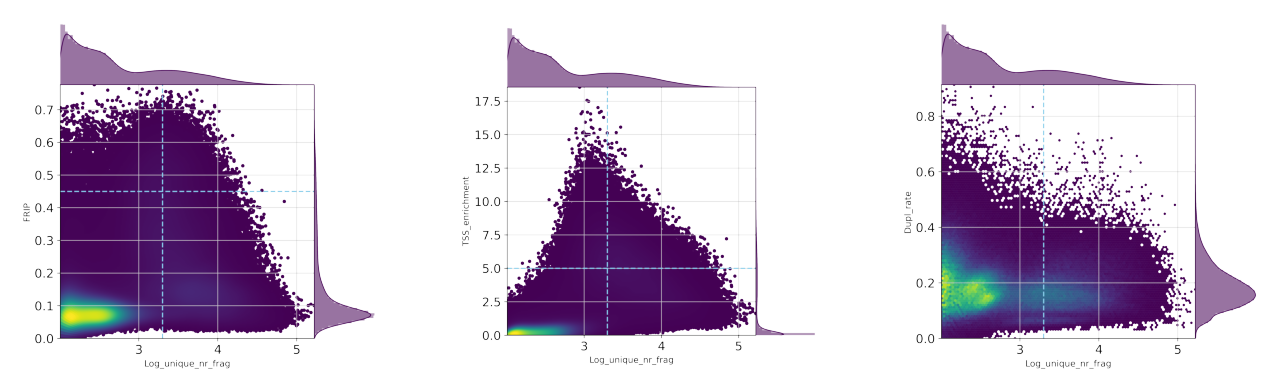

In [51]:
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [52]:
bc_passing_filters = {'alzheimers':[]}
bc_passing_filters['alzheimers'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters, open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['alzheimers'])} barcodes passed QC stats")

9909 barcodes passed QC stats


# Checkpoint load

In [ ]:
# Load if needed

fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}
adata = sc.read_h5ad(os.path.join(mg_state, 'alzheimers.h5ad'))
path_to_regions = {'alzheimers':os.path.join(mg_state, 'consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
metadata_bc = pickle.load(open(os.path.join(mg_state, 'quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(mg_state, 'quality_control/bc_passing_filters.pkl'), 'rb'))
atac_metadata = pickle.load(open(os.path.join(mg_state, 'atac_metadata.pkl'), 'rb'))



In [66]:
cell_data = adata.obs
cell_data['sample_id'] = 'alzheimers'
cell_data['celltype'] = cell_data['celltype'].astype(str)

# Topic Modelling

In [53]:
metadata_bc['alzheimers']

Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
ACTTTCACAAGCAACG-13           3.930185            3.900586           8515   
AGGACGAGTGGACAGT-14           3.626853            3.573684           4235   
TAATTCCAGAACTCCT-14           3.472464            3.418301           2968   
TCCCACACAACTACTG-14           3.621799            3.567026           4186   
CAGCTAAAGGGTCCCT-14           3.980458            3.929061           9560   
...                                ...                 ...            ...   
TCGCAGGAGACACTTC-8            2.110590            2.056905            129   
ACAATCGAGCGTCAAG-12           2.139879            2.037426            138   
CTTAATCGTAACGGCA-20           2.252853            2.045323            179   
GTCACCTCAGAGATGC-14           2.158362            2.071882            144   
GCCCGAATCTTCATAC-6            2.357935            2.264818            228   

                     Unique_nr_frag  Dupl_nr_frag  Dupl_rate  \
ACTTTCACAAGCAACG-13            7954           561   0.065884   
AGGACGAGTGGACAGT-14            3747           488   0.115230   
TAATTCCAGAACTCCT-14            2620           348   0.117251   
TCCCACACAACTACTG-14            3690           496   0.118490   
CAGCTAAAGGGTCCCT-14            8493          1067   0.111611   
...                             ...           ...        ...   
TCGCAGGAGACACTTC-8              114            15   0.116279   
ACAATCGAGCGTCAAG-12             109            29   0.210145   
CTTAATCGTAACGGCA-20             111            68   0.379888   
GTCACCTCAGAGATGC-14             118            26   0.180556   
GCCCGAATCTTCATAC-6              184            44   0.192982   

                     Total_nr_frag_in_regions  Unique_nr_frag_in_regions  \
ACTTTCACAAGCAACG-13                      1064                        978   
AGGACGAGTGGACAGT-14                      2580                       2284   
TAATTCCAGAACTCCT-14                      1483                       1297   
TCCCACACAACTACTG-14                      1997                       1767   
CAGCTAAAGGGTCCCT-14                      2920                       2574   
...                                       ...                        ...   
TCGCAGGAGACACTTC-8                         13                         11   
ACAATCGAGCGTCAAG-12                        12                         10   
CTTAATCGTAACGGCA-20                        15                         13   
GTCACCTCAGAGATGC-14                         4                          3   
GCCCGAATCTTCATAC-6                         19                         13   

                         FRIP  TSS_enrichment  
ACTTTCACAAGCAACG-13  0.122957        2.518127  
AGGACGAGTGGACAGT-14  0.609554        5.597534  
TAATTCCAGAACTCCT-14  0.495038        5.288406  
TCCCACACAACTACTG-14  0.478862        6.094288  
CAGCTAAAGGGTCCCT-14  0.303073        3.671378  
...                       ...             ...  
TCGCAGGAGACACTTC-8   0.096491        0.155000  
ACAATCGAGCGTCAAG-12  0.091743        0.000000  
CTTAATCGTAACGGCA-20  0.117117        0.000000  
GTCACCTCAGAGATGC-14  0.025424        0.050000  
GCCCGAATCTTCATAC-6   0.070652        0.415000  

[544968 rows x 10 columns]

In [54]:
from pycisTopic.cistopic_class import *

key = 'alzheimers'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key])),
                            n_cpu=30,
                            project=key,
                            split_pattern='-')


2022-11-12 17:39:24,834 cisTopic     INFO     Reading data for alzheimers
2022-11-12 17:56:23,067 cisTopic     INFO     metrics provided!
2022-11-12 17:57:41,850 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-11-12 17:58:23,810 cisTopic     INFO     Counting fragments in regions


2022-11-12 17:58:40,036	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2022-11-12 18:02:02,695 cisTopic     INFO     Creating fragment matrix


/data/leuven/338/vsc33838/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2734775001 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2022-11-12 18:02:38,924 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-11-12 18:02:51,711 cisTopic     INFO     Removing blacklisted regions
2022-11-12 18:02:52,872 cisTopic     INFO     Creating CistopicObject
2022-11-12 18:02:54,076 cisTopic     INFO     Done!


In [55]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,6,10,16],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = '/tmp/rayspill')

2022-11-12 18:03:25,747	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=1530785) 2022-11-12 18:03:40,789 cisTopic     INFO     Running model with 6 topics
(run_cgs_model pid=1530787) 2022-11-12 18:03:40,785 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=1530783) 2022-11-12 18:03:40,814 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=1530784) 2022-11-12 18:03:40,805 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=1530786) 2022-11-12 18:03:40,805 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=1530787) 2022-11-12 18:14:21,935 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=1530786) 2022-11-12 18:19:51,572 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=1530785) 2022-11-12 18:25:28,072 cisTopic     INFO     Model with 6 topics done!
(run_cgs_model pid=1530784) 2022-11-12 18:35:10,277 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=1530783) 2022-11-12 18:48:23,206 cisTopic     INFO     Model with 16

In [56]:
if not os.path.exists(os.path.join(mg_state, 'models')):
    os.makedirs(os.path.join(mg_state, 'models'))

pickle.dump(models, open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'wb'))

In [ ]:
models = pickle.load(open(os.path.join(mg_state, 'models/alzheimers_topics.pkl'), 'rb'))

<Figure size 512x384 with 0 Axes>

<Figure size 512x384 with 0 Axes>

<Figure size 400x400 with 0 Axes>

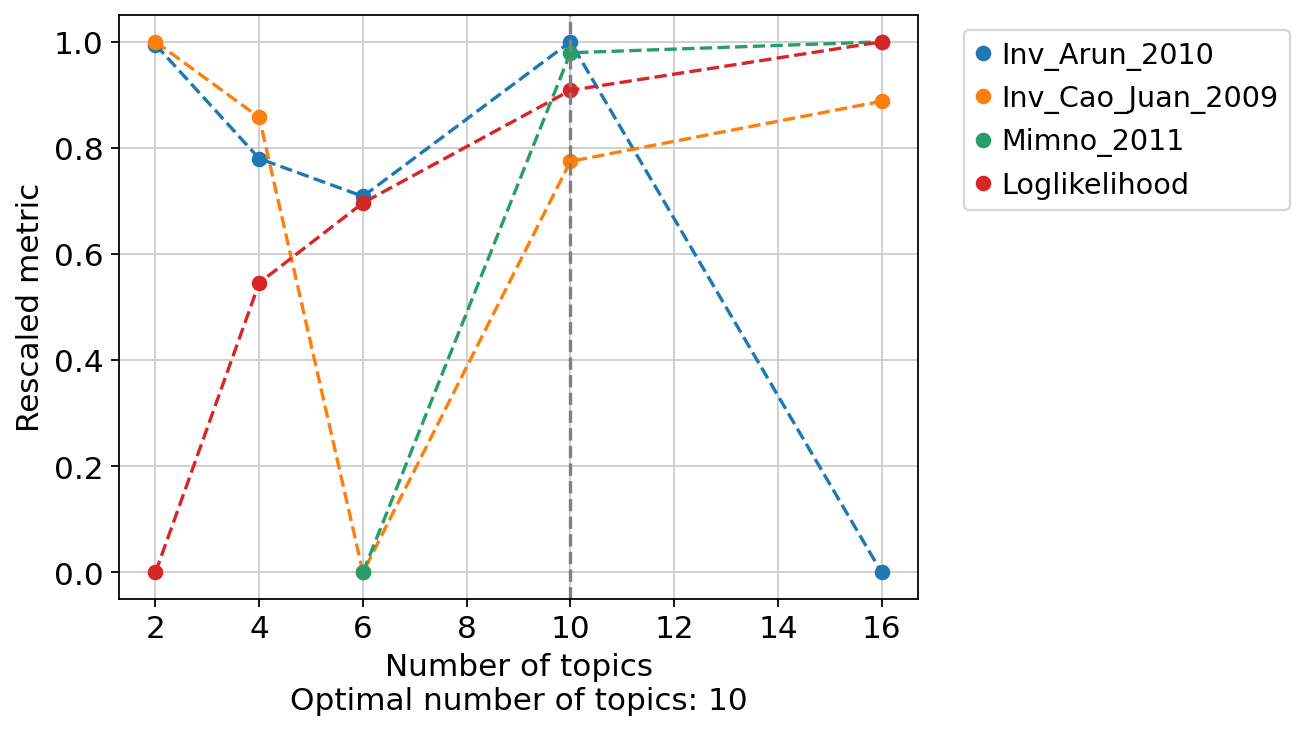

In [67]:
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=10,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)


In [58]:
cistopic_obj.add_cell_data(atac_metadata, split_pattern='-')
cistopic_obj.add_LDA_model(model)

pickle.dump(cistopic_obj, open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'wb'))

Columns ['barcode', 'sample_id'] will be overwritten


# Visualization of topic modelling

In [ ]:
cistopic_obj = pickle.load(open(os.path.join(mg_state, 'cistopic_obj.pkl'), 'rb'))

In [69]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)

2022-11-12 20:00:49,045 cisTopic     INFO     Running UMAP


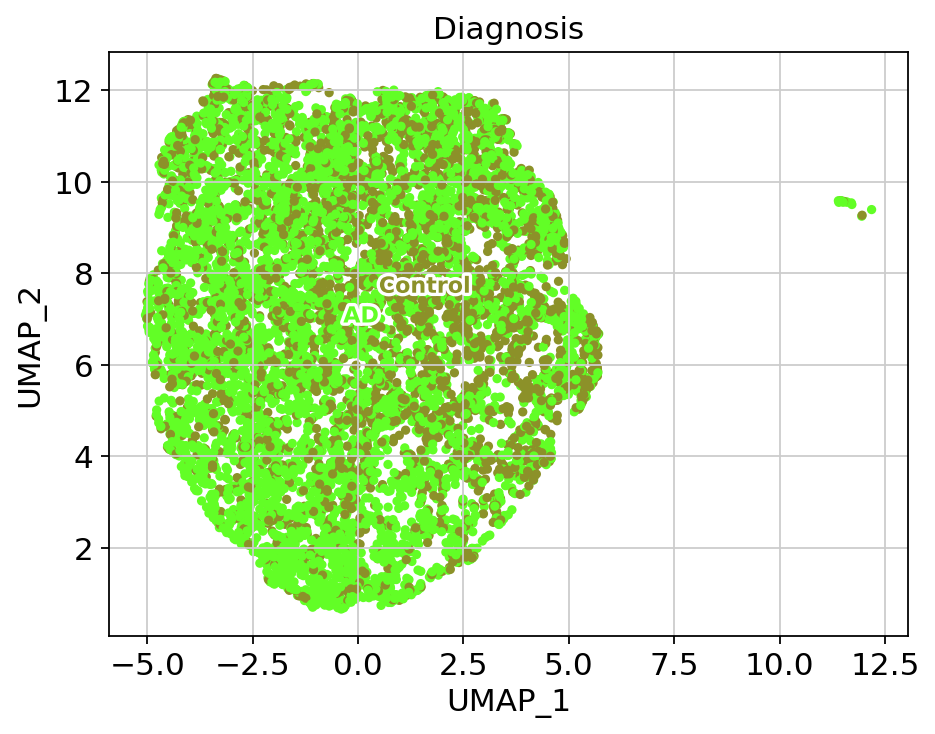

In [70]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['Diagnosis'])

Here we do the same plot using the UMAP coordinates in the metadata.

In [71]:
cmap = {'AD': 'red', 
        'Control': 'green'}

na_mask = cistopic_obj.cell_data['Diagnosis'].isna() == False

for diag in cmap.keys():
    cmask = (cistopic_obj.cell_data['Diagnosis'] == diag) & na_mask
    mpl.pyplot.scatter(cistopic_obj.cell_data[cmask]['UMAP_1'].values, 
                    cistopic_obj.cell_data[cmask]['UMAP_2'].values,
                    label=diag,
                    color=cmap[diag])
mpl.pyplot.legend()

In [ ]:
# plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 3)

# Inferring candidate enhancer regions

In [61]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [62]:
region_bin_topics_top3k

{'Topic1':                              Topic1
 chr2:176174953-176175453   0.000861
 chr11:117295391-117295891  0.000835
 chr6:123812590-123813090   0.000806
 chr11:135006727-135007227  0.000749
 chr8:23269759-23270259     0.000731
 ...                             ...
 chr15:49903155-49903655    0.000176
 chr9:99173754-99174254     0.000176
 chr6:53025180-53025680     0.000176
 chr12:1780285-1780785      0.000175
 chr11:34546485-34546985    0.000175
 
 [3000 rows x 1 columns],
 'Topic2':                             Topic2
 chr11:59615760-59616260   0.002412
 chr5:75336793-75337293    0.002292
 chr12:53379601-53380101   0.002073
 chr4:18021916-18022416    0.002010
 chr18:12377145-12377645   0.002002
 ...                            ...
 chr1:153633699-153634199  0.000372
 chr7:5530411-5530911      0.000372
 chr18:61894169-61894669   0.000371
 chr5:147782540-147783040  0.000371
 chr3:69080153-69080653    0.000371
 
 [3000 rows x 1 columns],
 'Topic3':                             Topic3
 c

In [63]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='Diagnosis', var_features=variable_regions, split_pattern = '-')

2022-11-12 18:49:01,751 cisTopic     INFO     Imputing drop-outs
2022-11-12 18:49:05,550 cisTopic     INFO     Scaling
2022-11-12 18:49:11,174 cisTopic     INFO     Keep non zero rows
2022-11-12 18:49:18,183 cisTopic     INFO     Imputed accessibility sparsity: 0.2729428354386797
2022-11-12 18:49:18,184 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-12 18:49:18,185 cisTopic     INFO     Done!
2022-11-12 18:49:18,186 cisTopic     INFO     Normalizing imputed data
2022-11-12 18:49:40,305 cisTopic     INFO     Done!
2022-11-12 18:49:40,311 cisTopic     INFO     Calculating mean
2022-11-12 18:49:42,811 cisTopic     INFO     Calculating variance
2022-11-12 18:49:59,915 cisTopic     INFO     Done!
2022-11-12 18:50:03,251 cisTopic     INFO     Formatting data for AD
2022-11-12 18:50:09,858 cisTopic     INFO     Computing p-value for AD
2022-11-12 18:51:12,639 cisTopic     INFO     Computing log2FC for AD
2022-11-12 18:51:14,183 cisTopic     INFO     AD done!
2022-11-12 18

In [64]:
if not os.path.exists(os.path.join(mg_state, 'candidate_enhancers')):
    os.makedirs(os.path.join(mg_state, 'candidate_enhancers'))

pickle.dump(region_bin_topics_otsu, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(mg_state, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(mg_state, 'candidate_enhancers/markers_dict.pkl'), 'wb'))

In [65]:
markers_dict

{'AD': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 'Control': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: []}

# Loading checkpoints

In [ ]:
region_bin_topics_otsu = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(state_dir, 'candidate_enhancers/markers_dict.pkl'), 'rb'))

# PycisTarget

In [148]:
markers_dict

{'AD': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 'Control': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: []}

In [72]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
# for DAR in markers_dict.keys():
#     regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
#     region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [75]:
db_fpath = '/data/leuven/338/vsc33838/mirror/motifs'
rankings_db = os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(db_fpath, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

In [76]:
if not os.path.exists(os.path.join(mg_state, 'motifs')):
    os.makedirs(os.path.join(mg_state, 'motifs'))

from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(mg_state, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 30,
    _temp_dir = '/tmp/ray_spill2',
    annotation_version = 'v10nr_clust',
    )

2022-11-12 20:04:11,980 pycisTarget_wrapper INFO     /scratch/leuven/338/vsc33838/odc_state/motifs folder already exists.
2022-11-12 20:04:12,664 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-11-12 20:04:12,665 cisTarget    INFO     Reading cisTarget database
2022-11-12 20:11:10,658 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu


2022-11-12 20:11:27,440	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(ctx_internal_ray pid=1548280) 2022-11-12 20:11:42,352 cisTarget    INFO     Running cisTarget for Topic1 which has 16825 regions
(ctx_internal_ray pid=1548288) 2022-11-12 20:11:43,124 cisTarget    INFO     Running cisTarget for Topic2 which has 5061 regions
(ctx_internal_ray pid=1548273) 2022-11-12 20:11:43,839 cisTarget    INFO     Running cisTarget for Topic3 which has 13947 regions
(ctx_internal_ray pid=1548293) 2022-11-12 20:11:44,386 cisTarget    INFO     Running cisTarget for Topic4 which has 6713 regions
(ctx_internal_ray pid=1548285) 2022-11-12 20:11:44,742 cisTarget    INFO     Running cisTarget for Topic5 which has 15197 regions
(ctx_internal_ray pid=1548292) 2022-11-12 20:11:45,100 cisTarget    INFO     Running cisTarget for Topic6 which has 11730 regions
(ctx_internal_ray pid=1548288) 2022-11-12 20:12:01,138 cisTarget    INFO     Annotating motifs for Topic2
(ctx_internal_ray pid=1548280) 2022-11-12 20:12:01,237 cisTarget    INFO     Annotating motifs for Topic1
(ctx_inter

2022-11-12 20:12:39,857	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=1550539) 2022-11-12 20:12:55,819 cisTarget    INFO     Running cisTarget for Topic1 which has 15032 regions
(ctx_internal_ray pid=1550544) 2022-11-12 20:12:55,927 cisTarget    INFO     Running cisTarget for Topic2 which has 1196 regions
(ctx_internal_ray pid=1550554) 2022-11-12 20:12:56,332 cisTarget    INFO     Running cisTarget for Topic3 which has 10105 regions
(ctx_internal_ray pid=1550535) 2022-11-12 20:12:56,798 cisTarget    INFO     Running cisTarget for Topic4 which has 4159 regions
(ctx_internal_ray pid=1550538) 2022-11-12 20:12:57,071 cisTarget    INFO     Running cisTarget for Topic5 which has 6226 regions
(ctx_internal_ray pid=1550533) 2022-11-12 20:12:57,237 cisTarget    INFO     Running cisTarget for Topic6 which has 7410 regions
(ctx_internal_ray pid=1550533) 2022-11-12 20:13:13,401 cisTarget    INFO     Annotating motifs for Topic6
(ctx_internal_ray pid=1550554) 2022-11-12 20:13:14,562 cisTarget    INFO     Annotating motifs for Topic3
(ctx_interna

2022-11-12 20:18:22,919	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1553055) 2022-11-12 20:18:31,824 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1553054) 2022-11-12 20:18:32,694 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1553056) 2022-11-12 20:18:33,894 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1553053) 2022-11-12 20:18:34,007 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1553051) 2022-11-12 20:18:34,081 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=1553052) 2022-11-12 20:18:34,712 DEM          INFO     Computing DEM for Topic5
2022-11-12 20:20:06,182 DEM          INFO     Forming cistromes
2022-11-12 20:20:07,909 DEM          INFO     Done!
2022-11-12 20:20:09,104 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/odc_state/motifs/DEM_topics_otsu_All
2022-11-12 20:20:09,180 pycisTarget_wrapper INFO     Running DEM without promoters for topics_otsu
2022-11-12 20:20:13,057 DEM          

2022-11-12 20:20:30,101	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1555975) 2022-11-12 20:20:38,990 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1555977) 2022-11-12 20:20:40,114 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1555974) 2022-11-12 20:20:40,767 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1555978) 2022-11-12 20:20:41,097 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1555973) 2022-11-12 20:20:41,148 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=1555976) 2022-11-12 20:20:41,507 DEM          INFO     Computing DEM for Topic1
2022-11-12 20:21:20,745 DEM          INFO     Forming cistromes
2022-11-12 20:21:23,056 DEM          INFO     Done!
2022-11-12 20:21:24,159 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/odc_state/motifs/DEM_topics_otsu_No_promoters
2022-11-12 20:21:24,295 pycisTarget_wrapper INFO     Loading cisTarget database for topics_top_3
2022-11-12 20:21:24,296 cisTar

2022-11-12 20:22:25,282	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


(ctx_internal_ray pid=1557469) 2022-11-12 20:22:41,182 cisTarget    INFO     Running cisTarget for Topic3 which has 3697 regions
(ctx_internal_ray pid=1557460) 2022-11-12 20:22:41,191 cisTarget    INFO     Running cisTarget for Topic2 which has 3869 regions
(ctx_internal_ray pid=1557466) 2022-11-12 20:22:41,185 cisTarget    INFO     Running cisTarget for Topic1 which has 3226 regions
(ctx_internal_ray pid=1557450) 2022-11-12 20:22:41,357 cisTarget    INFO     Running cisTarget for Topic4 which has 3556 regions
(ctx_internal_ray pid=1557464) 2022-11-12 20:22:41,445 cisTarget    INFO     Running cisTarget for Topic5 which has 3921 regions
(ctx_internal_ray pid=1557443) 2022-11-12 20:22:41,626 cisTarget    INFO     Running cisTarget for Topic6 which has 3697 regions
(ctx_internal_ray pid=1557466) 2022-11-12 20:22:57,751 cisTarget    INFO     Annotating motifs for Topic1
(ctx_internal_ray pid=1557450) 2022-11-12 20:22:57,938 cisTarget    INFO     Annotating motifs for Topic4
(ctx_internal_

2022-11-12 20:23:26,434	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(ctx_internal_ray pid=1558582) 2022-11-12 20:23:41,408 cisTarget    INFO     Running cisTarget for Topic1 which has 2865 regions
(ctx_internal_ray pid=1558576) 2022-11-12 20:23:41,412 cisTarget    INFO     Running cisTarget for Topic2 which has 818 regions
(ctx_internal_ray pid=1558578) 2022-11-12 20:23:41,469 cisTarget    INFO     Running cisTarget for Topic3 which has 2163 regions
(ctx_internal_ray pid=1558575) 2022-11-12 20:23:41,573 cisTarget    INFO     Running cisTarget for Topic4 which has 2076 regions
(ctx_internal_ray pid=1558566) 2022-11-12 20:23:41,708 cisTarget    INFO     Running cisTarget for Topic5 which has 1020 regions
(ctx_internal_ray pid=1558572) 2022-11-12 20:23:41,766 cisTarget    INFO     Running cisTarget for Topic6 which has 2033 regions
(ctx_internal_ray pid=1558566) 2022-11-12 20:23:56,859 cisTarget    INFO     Annotating motifs for Topic5
(ctx_internal_ray pid=1558572) 2022-11-12 20:23:57,730 cisTarget    INFO     Annotating motifs for Topic6
(ctx_internal_r

2022-11-12 20:25:09,786	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1559712) 2022-11-12 20:25:21,071 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1559714) 2022-11-12 20:25:21,176 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1559713) 2022-11-12 20:25:21,146 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1559715) 2022-11-12 20:25:21,198 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1559710) 2022-11-12 20:25:21,228 DEM          INFO     Computing DEM for Topic6
(DEM_internal_ray pid=1559711) 2022-11-12 20:25:21,208 DEM          INFO     Computing DEM for Topic5
2022-11-12 20:25:42,450 DEM          INFO     Forming cistromes
2022-11-12 20:25:43,842 DEM          INFO     Done!
2022-11-12 20:25:44,204 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/odc_state/motifs/DEM_topics_top_3_All
2022-11-12 20:25:44,283 pycisTarget_wrapper INFO     Running DEM without promoters for topics_top_3
2022-11-12 20:25:46,597 DEM        

2022-11-12 20:26:04,027	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(DEM_internal_ray pid=1560390) 2022-11-12 20:26:11,988 DEM          INFO     Computing DEM for Topic2
(DEM_internal_ray pid=1560391) 2022-11-12 20:26:12,208 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=1560388) 2022-11-12 20:26:12,386 DEM          INFO     Computing DEM for Topic3
(DEM_internal_ray pid=1560389) 2022-11-12 20:26:12,448 DEM          INFO     Computing DEM for Topic5
(DEM_internal_ray pid=1560405) 2022-11-12 20:26:12,478 DEM          INFO     Computing DEM for Topic4
(DEM_internal_ray pid=1560387) 2022-11-12 20:26:12,696 DEM          INFO     Computing DEM for Topic6
2022-11-12 20:26:24,671 DEM          INFO     Forming cistromes
2022-11-12 20:26:25,990 DEM          INFO     Done!
2022-11-12 20:26:26,347 pycisTarget_wrapper INFO     Created folder : /scratch/leuven/338/vsc33838/odc_state/motifs/DEM_topics_top_3_No_promoters
2022-11-12 20:26:26,435 pycisTarget_wrapper INFO     Loading cisTarget database for DARs
2022-11-12 20:26:26,436 cisTarget    

ValueError: A gene signature must have at least one gene.

In [77]:
import dill
menr = dill.load(open(os.path.join(os.path.join(state_dir, 'motifs'), 'menr.pkl'), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/leuven/345/vsc34561/ibp-2022-data/state/motifs/menr.pkl'

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic2')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic3')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic4')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic5')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic6')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic7')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic8')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic9')

In [ ]:
menr['DEM_topics_otsu_All'].DEM_results('Topic10')